<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>


This is part two of a pair of live training sessions to review the concepts of statistical inference laid out in the DataCamp courses [Statistical Thinking in Python I](https://learn.datacamp.com/courses/statistical-thinking-in-python-part-1) and [Statistical Thinking in Python II](https://learn.datacamp.com/courses/statistical-thinking-in-python-part-2). The concepts of those courses were reviewed and fortified in [Case Studies in Statistical Thinking](https://learn.datacamp.com/courses/case-studies-in-statistical-thinking). You can link to those courses by clicking on the badges below.

<div style="margin: auto; width: 400px;">

<a href="https://learn.datacamp.com/courses/statistical-thinking-in-python-part-1"><img src = "https://assets.datacamp.com/production/course_1549/shields/original/shield_image_course_1549_20191010-1-13inj9n?1570728356" width="100px"></a>
<a href="https://learn.datacamp.com/courses/statistical-thinking-in-python-part-2"><img src = "https://assets.datacamp.com/production/course_1550/shields/original/shield_image_course_1550_20180911-13-4iztc?1536680442" width="100px"></a>
<a href="https://learn.datacamp.com/courses/case-studies-in-statistical-thinking"><img src = "https://assets.datacamp.com/production/course_4674/shields/original/shield_image_course_4674_20190318-13-1c5k8sf?1552948884" width="100px"></a> 

</div>

In the Hacker Stats in Python Part 1 live training, we learned some basic ideas in nonparametric statistical inference using the plug-in principle. We applied those concepts to computing plug-in estimates and confidence intervals. Here, we will reinforce and extend those skills to:

- Construct confidence intervals and perform NHSTs comparing two treatments in a data set.
- Compute confidence intervals on two-dimensional data sets, investigating correlations and linear regressions.
- Review concepts behind null hypothesis significance tests (NHSTs).

While this live training can stand alone, I strongly encourage you to review the materials from Part 1.

## **Necessary packages**

I always import my packages at the top of a notebook or `.py` file. It is good style.

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Seed RNG
np.random.seed(3252)

# I want crisp graphics, so we'll output SVG
%config InlineBackend.figure_format = 'svg'

## **The Dataset**

We will use the same dataset as in Part 1, but will explore different aspects of it. As a reminder, the data set we will be working with comes from a study by [Beattie, et al.](https://doi.org/10.1098/rsos.160321) in which they used the [Glasgow Facial Matching Test](https://en.wikipedia.org/wiki/Glasgow_Face_Matching_Test) (GFMT, [original paper](https://doi.org/10.3758/BRM.42.1.286)) to investigate how sleep deprivation affects a human subject's ability to match faces, as well as the confidence the subject has in those matches. Briefly, the test works by having subjects look at a pair of faces. Two such pairs are shown below.

<p align="center">
<img src="https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/assets/gfmt_faces.png?raw=True" alt="GFMT faces" width="400px">
</p>
<br>


For each of 40 pairs of faces, the subject gets as much time as he or she needs and then says whether or not they are the same person. The subject then rates his or her confidence in the choice.

In this study, subjects also took surveys to determine properties about their sleep. The surveys provide three different metrics of sleep quality and wakefulness. 

- The Sleep Condition Indicator (SCI) is a measure of insomnia disorder over the past month. High scores indicate better sleep and scores of 16 and below indicate insomnia. 
- The Pittsburgh Sleep Quality Index (PSQI) quantifies how well a subject sleeps in terms of interruptions, latency, etc. A higher score indicates poorer sleep. 
- The Epworth Sleepiness Scale (ESS) assesses daytime drowsiness. Higher scores indicate greater drowsiness.

We will explore how the various sleep metrics are related to each other and how sleep disorders affect subjects' ability to discern faces and their confidence in doing so.

### Loading in the data set

We will load in the data set as in the previous live sesson on hacker stats.

In [2]:
# Read in the dataset
df = pd.read_csv(
    "https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/data/gfmt_sleep.csv?raw=True",
    na_values="*",
)

# Print header
df.head()

,participant number,gender,age,correct hit percentage,correct reject percentage,percent correct,confidence when correct hit,confidence when incorrect hit,confidence when correct reject,confidence when incorrect reject,confidence when correct,confidence when incorrect,sci,psqi,ess
0,8,f,39,65,80,72.5,91.0,90.0,93.0,83.5,93.0,90.0,9,13,2
1,16,m,42,90,90,90.0,75.5,55.5,70.5,50.0,75.0,50.0,4,11,7
2,18,f,31,90,95,92.5,89.5,90.0,86.0,81.0,89.0,88.0,10,9,3
3,22,f,35,100,75,87.5,89.5,NaN,71.0,80.0,88.0,80.0,13,8,20
4,27,f,74,60,65,62.5,68.5,49.0,61.0,49.0,65.0,49.0,13,9,12


For this session, we are particularly interested in the following columns:

- `percent correct`: Percentage of correct responses among all trials
- `confidence when correct`: Average confidence when the subject gave a correct response for for all trials
- `confidence when incorrect`: Average confidence when the subject gave an incorrect response for for all trials
- `sci`: The subject's Sleep Condition Indicator.
- `psqi`: The subject's Pittsburgh Sleep Quality Index.
- `ess`: The subject's Epworth Sleepiness Scale.

Going forward, it will be useful to separate the subjects into two groups, insomniacs and normal sleepers. We will therefore add an `'insomnia'` column to the DataFrame with True/False entries. Recall that a person is deemed an insomniac if their SCI is 16 or below.

In [3]:
# Add a column to the data frame for insomnia
df['insomnia'] = df['sci'] <= 16

With our data set in place, we can get moving with statistical inference.

## **Review of principles from last time**

In Part 1, we defined the following terms.

- **Cumulative distribution function (CDF)**: A probability distribution can be defined by its CDF, given by CDF(*x*) = probability of observing a value ≤ to *x*.
- **Generative distribution**: The unknown distribution from which the data are generated.
- **Empirical distribution**: The distribution defined entirely by observed data.
- **Empirical cumulative distribution function (ECDF)**: The cumulative distribution function (CDF) of the empirical distribution. It is defined as ECDF(*x*) = fraction of measured data points ≤ *x*.
- **Plug-in principle**: Approximate the generative distribution by the empirical distribution. That is, we make the approximation CDF(*x*) ≈ ECDF(*x*).
- **Confidence interval**: A *p*% confidence interval may be defined as follows. If an experiment is repeated over and over again, the estimate I compute will lie between the bounds of the *p*% confidence interval for *p*% of the experiments.
- **Bootstrap sample**: If I obtained *n* measurements, a bootstrap sample is constructed by drawing *n* values out of the empirical distribution. In practice, this amounts to randomly drawing data points out of the measured data set with replacement.
- **Bootstrap replicate**: A bootstrap replicate is the value of an estimate (e.g., a plug-in estimate) computed from a bootstrap sample.

We showed that we can compute many bootstrap replicates and then compute a confidence interval for an estimate by computing percentiles of the replicates.

### **Computing plug-in estimates**

The table below shows how to compute various plug-in estimates from a univariate set of measurements using NumPy.


| Property           | Plug-in estimate      |
|--------------------|-----------------------|
| mean               | `np.mean(x)`          |
| median             | `np.median(x)`        |
| variance           | `np.var(x)`           |
| standard deviation | `np.std(x)`           |
| _p_ percentile     | `np.percentile(x, p)` |



Two-dimensional distributions additionally have properties like covariances and correlations. For two-dimensional distributions, the plug-in estimates are:

| Property           | Plug-in estimate              |
|--------------------|-------------------------------|
| covariance         | `np.cov(x, y, ddof=0)[0, 1]`  |
| correlation        | `np.corrcoef(x, y)[0, 1]`     |

### **Functions from the Part 1**

We laid a lot of the groundwork we need in this live session in the previous one. We wrote functions that are useful for our hacker stats approaches to inference. First, we wrote a function to compute the *x*- and *y*-values for plotting ECDFs.

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n + 1) / n

    return x, y

We also wrote a pair of functions that enable us to draw many bootstrap replicates for a plug-in estimate.

In [5]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))

    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw `size` bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

### **Automating and organizing confidence intervals**

In our analysis in Part 1, we took an array of data, computed the x- and y-values for an ECDF, defined a function to compute a plug-in estimate (in our case, the mean), used the function to compute the estimate, generated bootstrap replicates of the estimate, and computed a confidence interval. We did this for two categories, normal sleepers and insomniacs.

At various points in our analyses, we might like to access these results. It is therefore useful to define a class to compute and store the results of an ECDF, plug-in estimate, and confidence interval calculation for a one-dimensional data set. Many participants in this live training may not be familiar with Python's classes, so we will instead mimic a class by writing a function that does the necessary computations and returns the results in a dictionary.

In [6]:
def plugin_summary(
    data, func, ptiles=(2.5, 97.5), n_bs_reps=10000, label=None
):
    """Compute and store ECDF, plug-in estimate, and confidence
    intervals in a dictionary."""
    # Initialize output dictionary
    summary = {}

    # Store data and settings
    summary["data"] = data
    summary["func"] = func
    summary["ptiles"] = ptiles
    summary["n_bs_reps"] = n_bs_reps
    summary["label"] = label

    # Compute ECDF x and y values
    summary["ecdf_x"], summary["ecdf_y"] = ecdf(data)

    # Compute plug-in estimate
    summary["estimate"] = func(data)

    # Compute bootstrap confidence interval
    summary["bs_reps"] = draw_bs_reps(data, func, size=n_bs_reps)
    summary["conf_int"] = np.percentile(summary["bs_reps"], ptiles)

    return summary

Importantly, whenever we instantiate this class, we get an object that has the values for plotting an ECDF, a plug-in estimate, and a bootstrap confidence interval for that measurement. For example, to repeat the analyses from last time, we can pull out the percent correct for normal sleepers and for insomniacs and instantiate the class.

In [7]:
# Initialize list of plug-in summaries
summaries = []

# Iterate through groups and instantiate conf intervals
for label, group in df.groupby("insomnia"):
    summaries.append(
        plugin_summary(
            group["percent correct"].dropna().values, np.mean, label=label,
        )
    )

# Adjust label names to be descriptive
for i, _ in enumerate(summaries):
    summaries[i]["label"] = "insomniac" if summaries[i]["label"] else "normal"

We now have a list of dictionaries that contain our analyses. Conveniently, we have the data set, what function was used to compute the plug-in estimate, the percentiles used for the confidence interval, the number of bootstrap replicates we used, which category we are considering (insomniacs vs. normal sleepers), the *x*- and *y*-values for the ECDF, the plug-in estimate for the mean, the bootstrap replicates we drew and the confidence interval. A treasure trove!

Now that we have this convenient way of storing our analysis results, we should modify our plotting function from last time to plot confidence intervals that are stored in these dictionaries.

In [8]:
def plot_conf_ints(summaries, palette=None):
    """Plot confidence intervals with estimates."""
    # Set a nice color palette
    if palette is None:
        palette = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
    elif type(palette) == str:
        palette = [palette]

    labels = [ci["label"] for ci in summaries][::-1]
    estimates = [ci["estimate"] for ci in summaries][::-1]
    conf_intervals = [ci["conf_int"] for ci in summaries][::-1]
    palette = palette[: len(labels)][::-1]

    # Set up axes for plot
    fig, ax = plt.subplots(figsize=(5, len(labels) / 2))

    # Plot estimates as dots and confidence intervals as lines
    for i, (label, est, conf_int) in enumerate(
        zip(labels, estimates, conf_intervals)
    ):
        color = palette[i % len(palette)]
        ax.plot(
            [est],
            [label],
            marker=".",
            linestyle="none",
            markersize=10,
            color=color,
        )

        ax.plot(conf_int, [label] * 2, linewidth=3, color=color)

    # Make sure margins look ok
    ax.margins(y=0.25 if len(labels) < 3 else 0.125)

    return ax

We can now put this class to use to make two of our plots from Part 1. We'll start with the ECDFs.

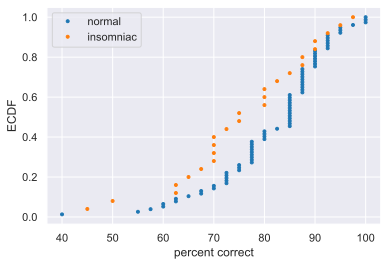

In [9]:
# Dictionary connecting category to color
colors = {"normal": "#1f77b3", "insomniac": "#ff7f0e"}

# Plot the ECDFs
for s in summaries:
    _ = plt.plot(
        s["ecdf_x"],
        s["ecdf_y"],
        marker=".",
        linestyle="none",
        label=s["label"],
        color=colors[s["label"]],
    )
_ = plt.xlabel("percent correct")
_ = plt.ylabel("ECDF")
_ = plt.legend()

And now the confidence intervals.

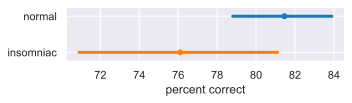

In [10]:
ax = plot_conf_ints(summaries)
_ = ax.set_xlabel('percent correct')

## **Our approach**

We are now all set to continue with statistical inference on this data set. In this live training, we will address the following questions (with question (1) answered in Part 1 and reviewed above).

2. How different is *confidence* in facial matching for insomniacs versus normal sleepers?
3. How are the different sleep metrics correlated?
4. How do sleep metrics influence facial matching performance?

Along the way, we will introduce the necessary new theoretical and technical concepts.

---

<center><h1> Q&A 1</h1> </center>

---

## **2. Confidence of insomniacs versus normal sleepers**

We have seen that there seems to be a difference in performance between normal sleepers and insomniacs. Now, let's compare how well the subjects *think* they are doing in their responses. We will investigate their confidence when correct and incorrect in the face matching tasks for both insomniacs and normal sleepers. We start by extracting the measurements from the DataFrame as NumPy arrays.

In [11]:
# Extract confidences for normal sleepers
conf_corr_normal = (
    df.loc[~df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_normal = (
    df.loc[~df["insomnia"], "confidence when incorrect"].dropna().values
)

# Extract confidences for insomniacs
conf_corr_insom = (
    df.loc[df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_insom = (
    df.loc[df["insomnia"], "confidence when incorrect"].dropna().values
)

### **Performing the analysis (the automated way)**

The analysis pipeline is much the same as we did for looking at the percent correct in the first lesson. We will again compute means and confidence intervals of the mean. We can conveniently use our `plugin_summary()` functions to do all of the calculations and give us a dictionary with the results.

In [12]:
# Put into classes
conf_corr_normal = plugin_summary(
    conf_corr_normal, np.mean, label="normal when correct",
)
conf_incorr_normal = plugin_summary(
    conf_incorr_normal, np.mean, label="normal when incorrect",
)
conf_corr_insom = plugin_summary(
    conf_corr_insom, np.mean, label="insomniac when correct"
)
conf_incorr_insom = plugin_summary(
    conf_incorr_insom, np.mean, label="insomniac when incorrect"
)

### **EDA**

While we did just compute confidence intervals, we should always do a bit of EDA to check things out. We will plot the ECDFs of all four classes (confidence when correct and incorrect for normal sleepers and insomniacs) and overlay them on the same plot.

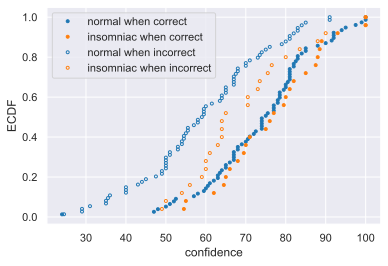

In [13]:
# Dictionary of kwargs for convenience
kwargs = {'marker': '.', 'linestyle': 'none'}

# Plot ECDFs
_ = plt.plot(
    conf_corr_normal["ecdf_x"],
    conf_corr_normal["ecdf_y"],
    color="#1f77b3",
    label=conf_corr_normal["label"],
    **kwargs,
)
_ = plt.plot(
    conf_corr_insom["ecdf_x"],
    conf_corr_insom["ecdf_y"],
    color="#ff7f0e",
    label=conf_corr_insom["label"],
    **kwargs,
)
_ = plt.plot(
    conf_incorr_normal["ecdf_x"],
    conf_incorr_normal["ecdf_y"],
    color="#1f77b3",
    fillstyle="none",
    label=conf_incorr_normal["label"],
    **kwargs,
)
_ = plt.plot(
    conf_incorr_insom["ecdf_x"],
    conf_incorr_insom["ecdf_y"],
    color="#ff7f0e",
    fillstyle="none",
    label=conf_incorr_insom["label"],
    **kwargs,
)

# Adjust labels
_ = plt.xlabel("confidence")
_ = plt.ylabel("ECDF")
_ = plt.legend()

We see a few striking trends directly from the ECDF.

1. Regardless of sleep quality, subjects are less confident in their responses when they are wrong.
2. When they are right, insomniacs and normal sleepers seem to have the same level of confidence in their responses.
3. When they are wrong, insomniacs have more confidence in their responses than normal sleepers.

This last point is really interesting. The insomniacs seem less likely to *know when they are wrong.* This kind of cognitive impairment could have real repercussions in how they go about their lives. We will give this last difference special attention.

### **Plug-in estimates and confidence intervals**

We have already computed the plug-in estimates for the mean and confidence intervals when we instantiated the classes. Let's compare them.

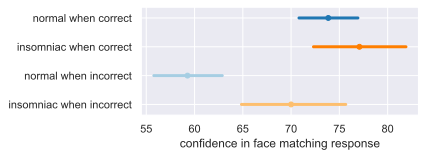

In [14]:
# Make plot of confidence intervals
ax = plot_conf_ints(
    [conf_corr_normal, conf_corr_insom, conf_incorr_normal, conf_incorr_insom],
    palette=['#1f77b3', '#ff7f00', '#a6cee3', '#fdbf6f']
)

_ = ax.set_xlabel("confidence in face matching response")

The evidence from this plot is clear. Insomniacs are more confident that they have provided a correct answer when they have not. The difference is about 10% on the confidence scale, which is about 20% of the entire range of responses from subjects about their confidence. If we were to perform the experiment again, we would very likely continue to see this discrepancy.

### Defining null hypothesis significance tests

We have already drawn telling conclusions from the data from the analysis above. Considering the confidence when incorrect, the rightward shift of the ECDF for insomniacs relative to normal sleepers strongly suggests the overconfidence of insomniacs. The confidence intervals make clear that this effect is not due to the inherent variability among participants and the small sample size. We really could conclude our analysis there.

Nonetheless, we will proceed to do a null hypothesis significance test. In some fields, this is referred to as an A/B test. I do so primarily because they are widely used and are important to know how to do and to interpret. I will give further commentary about why the results of NHST should not carry as much weight as conclusions derived from graphical EDA with ECDFs and calculation of confidence intervals after we perform the analysis.

I begin by reviewing what a NHST is. A typical hypothesis test consists of these steps.

1. Clearly state the hypothesis being considered, referred to as the **null hypothesis**.
2. Define a **test statistic**, a scalar value that you can compute from data, almost always a statistical functional of the empirical distribution. Compute it directly from your measured data.
3. *Simulate* data acquisition for the scenario where the null hypothesis is true. Do this many times, computing and storing the value of the test statistic each time.
4. The fraction of simulations for which the test statistic is at least as extreme as the test statistic computed from the measured data is called the **p-value**, which is what you report.

We need to be clear on our definition here. **The p-value is the probability of observing a test statistic being at least as extreme as what was measured if the null hypothesis is true.** It is exactly that, and nothing else. It is not the probability that the null hypothesis is true. In the frequentist interpretation of probability, we cannot assign a probability to the truth of a hypothesis.

A complete definition of a hypothesis test then has the following components.

- The null hypothesis.
- The test statistic.
- What it means to be at least as extreme. 

All of the named hypothesis tests you may have heard of, like the Student-t test, the Mann-Whitney U-test, Welch’s t-test, etc., describe a specific hypothesis with a specific test statistic with a specific definition of what it means to be at least as extreme (e.g., one-tailed or two-tailed). I can never remember what these are, nor do I encourage you to; you can always look them up. (I like [Kanji's *100 Statistical Tests*](https://dx.doi.org/10.4135/9781849208499) for this purpose.) Rather, you should just clearly write out what your test is in terms of the hypothesis, test statistic, and definition of extremeness.

### **Performing a NHST**

To perform a hypothesis test using hacker stats, we will follow the prescription laid out above. We of course have to start by specifying our test.

- Null hypothesis: The generative distributions for reported confidence is the same for insomniacs as it is for normal sleepers.
- Test statistic: Mean confidence of normal sleepers minus that of insomniacs.
- At least as extreme as: The test statistic is less than or equal to the observed difference of means.

The bread and butter of conducting a hypothesis test is simulating data acquisition under the null hypothesis. For this specific hypothesis, that the distributions are the same, there is a very straight-forward way of simulating it. Let `x` and `y` be our two arrays, with `m` entries in `x` and `n` entries in `y`.

1. Concatenate the two data sets into one. This is done with `np.concatenate((x, y))`.
2. Randomly scramble the order of the combined data set. This is accomplished using `np.random.permutation()`.
3. Designate the first `m` entries in this scrambled array to be "`x`" and the remaining to be "`y`."

Having simulated the data acquisition process, we then use these new "`x`" and "`y`" arrays to compute the test statistic.

This simulation is exact; it is as if the labels of the data set (in this case "normal sleeper" and "insomniac") have no meaning; hence the distributions of the two data sets are entirely equal. Note that we are *not* say what the distribution is, only that the two data sets have the *same* distribution. 

A test done in this way is referred to as a **permutation test**. A **permutation sample** is akin to a bootstrap sample; it is a new pair of data sets generated after scrambling the concatenated data set. A **permutation replicate** is a value of the test statistic computed from a permutation sample, in this case the difference of means.

Let's code up the functions to do the test, starting with generating the permutation sample.

In [15]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

We need to provide a function that takes in two data sets (a permutation sample or the original data sets) and computes the test statistic. In our case, this is the difference of means.

In [16]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    return np.mean(data_1) - np.mean(data_2)

Finally, we can write a function to generate multiple permutation replicates.

In [17]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

We'll start with the confidence when giving correct answers to the face matching test for insomniacs versus normal sleepers. We start by computing the test statistic from the actual measurements.

In [18]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_corr_normal["data"], conf_corr_insom["data"])

# Take a look
test_stat

-3.22935064935065

Now, we'll draw permutation replicates.

In [19]:
# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_corr_normal["data"], conf_corr_insom["data"], diff_of_means, size=10000
)

Now, we'll see what fraction were less than or equal to the test statistic calculated from the measured data sets.

In [20]:
# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.1596

In this case, the p-value is about 0.15, which means that about 15% of the time, the null hypothesis that the confidence when correct for insomniacs and normal sleepers is the same will generate a difference of means at least as different in magnitude than what was observed. The data are then commensurate with the null hypothesis; they do not serve to rule out that hypothesis.

Now, let's do the same analysis for the case where the subjects responded incorrectly to the face matching test.

In [21]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_incorr_normal["data"], conf_incorr_insom["data"])

# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_incorr_normal["data"], conf_incorr_insom["data"], diff_of_means, size=10000
)

# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.0016

This p-value is much smaller. Only 0.1 or 0.2% of the permutation samples had a difference of means less than or equal to what was observed. According to this result, it is unlikely that the observed data set could have been generated by identical distributions for normal sleepers and insomniacs. We already knew this from our analysis of the confidence intervals, and this is the icing on the cake, to borrow a phrase from [Allen Downey](http://www.allendowney.com/wp/).

### **Do not overemphasize NHSTs**

It is important to know exactly what an NHST gives you, a p-value. It is the probability of observing a test statistic being at least as extreme as what was measured if the null hypothesis were true. To put interpretation of the p-value in perspective, we can compare to the interpretation of plug-in estimates and confidence intervals. Let's consider three questions addressed by these calculations.

1. **Plug-in estimate**: How different are the means of the two samples?
2. **Confidence interval**: If we were to do the experiment again, how similar would our plug-in estimates be?
3. **NHST**: What is the probability of observing a difference in means of the two samples at least as large as the observed difference in means, if the two samples in fact have the same generative distribution?

I contend that a person thinking about their dataset might naturally ask the first two questions, but the third question is convoluted and of little practical interest.

To add further perspective, say we made trillions of measurements of two different samples and their mean differs by one part per million. This difference, though tiny, would still give a low p-value, and therefore often be deemed "statistically significant." But, ultimately, it is the size of the difference, or the **effect size**, relative to the experiment-to-experiment variation, that we care about.

Put succinctly: **Statistical significance and practical significance are not the same thing.**

---

<center><h1> Q&A 2</h1> </center>

---

## **3. Correlation of sleep metrics**

For the next study of the data set, we will explore the correlations among the three sleep/drowsiness metrics. Remember that two variables are **correlated** if one is high while the other is high. They are anticorrelated if one is high while the other is low. And they are said to be uncorrelated if the level of one is not related to the level of the other.

We can do a quick exploration of the relationship between each pair of sleep indexes by making scatter plots of each pair of indexes. This is conveniently accomplished using seaborn's `pairplot()` function.

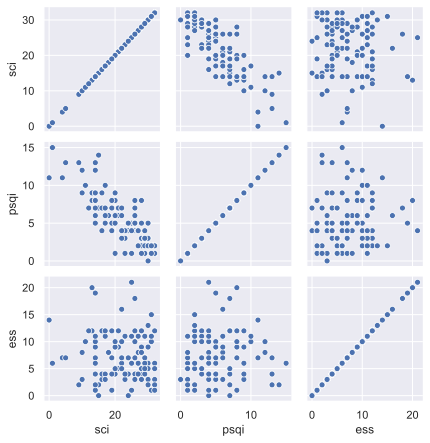

In [22]:
_ = sns.pairplot(df[['sci', 'psqi', 'ess']], diag_kind=None, height=2)

In glancing at these plots, the SCI and PSQI are clearly anticorrelated. This makes sense; they are both assess a similar feature of the subjects, the quality of nighttime sleep. Their scales are such that quality sleep is a high number in the SCI and a low number in the PSQI, so we would expect them to be anticorrelated.

However, visually at least, the ESS does not seem to correlate with SCI or PQSI. Recall that ESS is a measure of daytime drowsiness. We might expect that to correlate with sleep quality, but it does not seem to, at least graphically (though the analysis we will soon do may show that it does). Previous studies (e.g., [this one](http://dx.doi.org/10.1016/j.smrv.2009.04.002)) have shown that insomniacs experience hyperarousal, meaning that they are not drowsy as a result of their poor sleep. This would suggest that we should not be surprised by a lack of correlation between SCI and ESS.

### **Plug-in estimate for correlation**

With the graphical analysis out of the way, let's investigate the Pearson correlation between the pairs of metrics. We can compute the plug-in estimate using `np.corrcoef()`, first extracting the data as NumPy arrays. Remember that the Pearson correlation is 1 for perfect correlation, –1 for perfect anticorrelation, and zero for complete absence of correlation.

In [23]:
# Extract all three sleep/drowsiness metrics as NumPy arrays
sci = df['sci'].dropna().values
psqi = df['psqi'].dropna().values
ess = df['ess'].dropna().values

# Compute Pearson correlation between each pair
rho_sci_psqi = np.corrcoef(sci, psqi)[0, 1]
rho_sci_ess = np.corrcoef(sci, ess)[0, 1]
rho_psqi_ess = np.corrcoef(psqi, ess)[0, 1]

# Print the result
print('plug-in SCI-PSQI correlation:', rho_sci_psqi)
print('plug-in SCI-ESS correlation: ', rho_sci_ess)
print('plug-in PSQI-ESS correlation:', rho_psqi_ess)

plug-in SCI-PSQI correlation: -0.8366404153156871
plug-in SCI-ESS correlation:  -0.08930808942621958
plug-in PSQI-ESS correlation: 0.06160925920530207


Indeed, the plug-in estimates suggest that SCI and PSQI are strongly anticorrelated, but the SCI and PSQI are not really correlated with ESS.

### **Bootstrap confidence intervals for correlation**

At face, it may seem more difficult to compute bootstrap confidence intervals for correlation, we are going to have to sample out of *two* arrays. However, we can again directly apply the plug-in principle and rely on our coding skills to do it.

Consider for a moment the SCI and PSQI. Each individual subject was tested for these two sleep metrics. We cannot sample out of the array of SCI's and PSQI's independently, since they were measured *together* for each subject. Instead, we will choose a *subject* at random, and then record *both* his or her SCI and PSQI score as we build our bootstrap sample. Stated another way, we randomly choose *pairs* of scores.

This procedure is called **pairs bootstrap**. To implement pairs bootstrap on a pair of arrays of equal length, we randomly sample an *index* of the arrays, and then select the pair of values that share that index. 

Let's write a function to draw bootstrap pairs. As with our function for drawing bootstrap replicates for one-dimensional data, we will supply a function to compute the estimate as an argument. It must have the call signature `func(x, y)`, taking two arrays as arguments and returning a scalar result.

In [24]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

Now that we have this function in place, we can write our function to compute the Pearson correlation.

In [25]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

Ok, let's draw our bootstrap replicates! We will do it for each pair of sleep indexes, SCI–PSQI, SCI–ESS, and PSQI–ESS. 

In [26]:
# Pairs bootstrap replicates of correlation
sci_psqi_reps = draw_bs_pairs(sci, psqi, pearson_r, size=10000)
sci_ess_reps = draw_bs_pairs(sci, ess, pearson_r, size=10000)
psqi_ess_reps = draw_bs_pairs(psqi, ess, pearson_r, size=10000)

Now that we have our replicates, we can compute the confidence intervals, again by taking percentiles as we have done in the one-dimensional case.

In [27]:
# Pairs bootstrap confidence intervals
sci_psqi_conf_int = np.percentile(sci_psqi_reps, [2.5, 97.5])
sci_ess_conf_int = np.percentile(sci_ess_reps, [2.5, 97.5])
psqi_ess_conf_int = np.percentile(psqi_ess_reps, [2.5, 97.5])

To plot the results, we would like to use our `plot_conf_ints()` function. It expects a dictionary has `label`, `estimate`, and `conf_int` keys.

In [28]:
sci_psqi = dict(
    label="SCI–PSQI", estimate=rho_sci_psqi, conf_int=sci_psqi_conf_int
)
sci_ess = dict(
    label="SCI–ESS", estimate=rho_sci_ess, conf_int=sci_ess_conf_int,
)
psqi_ess = dict(
    label="PSQI–ESS", estimate=rho_psqi_ess, conf_int=psqi_ess_conf_int,
)

Now that we have them in convenient dictionaries, we can make our plot of the confidence intervals of the correlations.

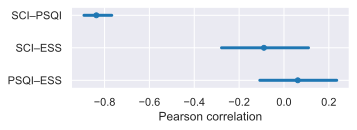

In [29]:
# Make plot
_ = plot_conf_ints([sci_psqi, sci_ess, psqi_ess], palette="#1f77b3",)
_ = plt.xlabel("Pearson correlation")

There is very clearly strong correlation between SCI and PSQI, but no real correlation between those metrics and the ESS metric for daytime drowsiness.

---

<center><h1> Q&A 3</h1> </center>

---

## **4. Effect of sleep quality on performance**

We have just investigate how the different sleep metrics are correlated. Now, we turn our attention to how the sleep metrics affect performance in the face matching test. We will start by considering the SCI. As usual, we'll do a little EDA and make a scatter plot of the percent correct versus SCI.

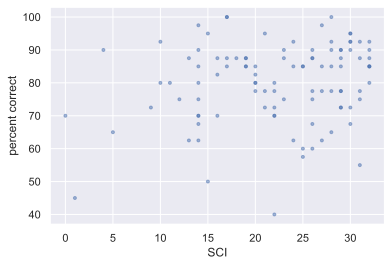

In [30]:
_ = plt.plot(
    df["sci"], df["percent correct"], marker=".", linestyle="none", alpha=0.5,
)
_ = plt.xlabel("SCI")
_ = plt.ylabel("percent correct")

If we squint, we can see there may be better scores for higher SCI. We will attempt to quantify this.

We could compute the correlation between SCI and percent correct in the test, similarly to how we computed correlation between SCI and PSQI. But this is not really what we want to do. We want to know how SCI *explains* performance in the test. Contrast that with the analysis we just did in computing correlation of SCI and PSQI. We did not try to assert that one influences the other, but that the same thing, namely nighttime sleep quality, may influence them both, and hence make them correlated. In that case, a correlation was appropriate, but now, we are interested in how SCI *influences* performance. So here, a linear regression is appropriate.

This subtle difference may be explained by investigating the mathematical expressions for correlation and for the slope computed from a linear regression by least squares.

\begin{align}
\text{Pearson correlation} = \frac{\sigma_{xy}}{\sigma_x\,\sigma_y}, \\[1em]
\text{slope of lin. reg.} = \frac{\sigma_{xy}}{\sigma_x^2}.
\end{align}

Here, $\sigma_{xy}$ is the covariance of $x$ and $y$, $\sigma_x^2$ is the variance of $x$, and $\sigma_y^2$ is the variance of $y$. The Pearson correlation is a comparison of covariance to the geometric mean of the variances of the individual variables. The slope computed from linear regression by least squares is a comparison of the covariance to the variance in the x-variable, the variable that may explain the variation in y-variable. The slope of the linear regression is thus asymmetric; we are looking at the effects of *x* on *y*, in this case the effects of SCI on percent correct.

### **Performing a linear regression**

When we perform a linear regression, we seek to find the line that is closest to the data in a least squares sense. This means that we want to find the line that passes through the data such that the sum of the square of the distance between the line and each data point is as small as possible.

This calculation involves some beautiful mathematics, and the result is given above. The slope of the line is given by the ratio of the covariance to the variance in x. The intercept is given by the mean of the y-values minus the slope times the mean of the x-values. We can directly compute the slope and intercept using these formulas.

In [31]:
# Extract SCI and percent correct from data frame
sci = df['sci'].dropna().values
pcorr = df['percent correct'].dropna().values

# Compute slope
cov = np.cov(sci, pcorr)
slope = cov[0, 1] / cov[0, 0]

# Compute intecept
intercept = np.mean(pcorr) - slope * np.mean(sci)

# Print results
print("slope:     ", slope)
print("intercept: ", intercept)

slope:      0.32137397685384794
intercept:  72.99806320116292


Indeed, we see what our squinting suggested; there is a slight positive slope. For every unit increase in SCI, users get an improvement of 0.32% in their performance on the facial matching test.

I pause to note here that the slope (which is of primary interest) and the intercept are numbers that are computed directly from the data. *They are therefore plug-in estimates.* All of the same principles we have been using still apply.

I wanted to show you the respective formulas for the slope and intercept to make that point clear; we are "just" computing variances and means directly from the data and taking some ratios. In practice, we can more conveniently compute the slope and intercepts for a linear regression using the `np.polyfit()` function. It fits (*x*, *y*) data with a polynomial of arbitrary degree. A line is a polynomial of degree 1, so we can use it!

In [32]:
slope, intercept = np.polyfit(sci, pcorr, deg=1)

# Show that it's the same as our formulas
print("slope:     ", slope)
print("intercept: ", intercept)

slope:      0.32137397685384766
intercept:  72.99806320116292


### **Bootstrap replicates of linear regression parameters**

Since the linear regression parameters are computed directly from data, we can again apply pairs bootstrap and compute the parameters. Since we might also be interested in the intercept, we can adapt our `draw_bs_pairs()` function to return two arrays of bootstrap replicates (one for slope and one for intercepts).

In [33]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

Let's use this function to get some bootstrap replicates for the slope and intercepts!

In [34]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(sci, pcorr, size=10000)

As before, we can compute the confidence intervals using `np.percentile()`. The slope is of primary interest, so we can compute its confidence interval.

In [35]:
# Compute confidence interval from percentiles
conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])

# Take a look
conf_int

array([-0.02088422,  0.64299612])

The confidence interval juuuust crosses zero, suggesting that most likely there is a real positive slope, meaning that SCI does inform performance on the test.

I will visualize the linear regression on the scatter plot. To do so, I like to plot a bunch of the regression lines on the same plot as the scatter plot so I can see how the line might change if we were to do the experiment again.

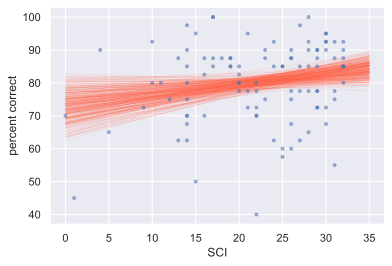

In [36]:
# x-values for lines
x = np.array([0, 35])

# Plot 300 lines (thin with a bit of transparency)
for slp, intcpt in zip(bs_slope_reps[:300], bs_intercept_reps[:300]):
    _ = plt.plot(
        x, slp * x + intcpt, linewidth=0.5, alpha=0.2, color="tomato"
    )

# Plot data
_ = plt.plot(sci, pcorr, marker=".", linestyle="none", alpha=0.5,)

# Label axes
_ = plt.xlabel("SCI")
_ = plt.ylabel("percent correct")

Indeed in this graphic, we see that on rare occasion the slope is close to zero or slightly negative, but most of the lines show positive slope.

## A NHST for a linear regression

The above analysis, in which we computed a plug-in estimate for the slope, its confidence interval, and created a visualization, is sufficient, in my opinion, for this analysis. Nonetheless, we might want to perform a null hypothesis test. Remember, we have to specify three things; here is a reasonable test.

1. Null hypothesis: The SCI is completely inconsequential when it comes to performance on the facial matching test.
2. Test statistic: The slope of the linear regression line.
3. At least as extreme as: The slope is greater than or equal to what was acquired from the measured data.

Again, the trick is in simulating the null hypothesis. If the SCI has no bearing on the performance of the facial matching test, we can scramble the subjects' SCI scores, thereby decoupling them from the test scores. We can then compute the slope from the scrambled dataset. This is another version of a permutation test.

Let's code up our function to draw permutation replicates of the slope.

In [37]:
def draw_perm_reps_slope(x, y, size=1):
    """Draw permuation replicates of the slope from lin. reg."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Scramble x-values
        x_perm = np.random.permutation(x)

        # Compute the slope
        perm_replicates[i] = np.polyfit(x_perm, y, deg=1)[0]

    return perm_replicates

Now we can draw our replicates (we'll take 10,000 of them) and compute the p-value.

In [38]:
# Draw permutation replicates
perm_reps = draw_perm_reps_slope(sci, pcorr, size=10000)

# p-value
np.sum(perm_reps >= slope) / 10000

0.02

Our p-value is about 0.02, suggesting that the measured data may not be commensurate with the null hypothesis being true. This again confirms what we already saw in our analysis of the plug-in estimate with confidence interval.

---

<center><h1> Q&A 4</h1> </center>

---

## **Conclusions**

We have seen that even when we have multidimensional data, the principles we apply to do nonparametric statistical inference are the same: We directly apply the plug-in principle and the frequentist interpretation of probability. We sometimes have to do bootstrapping with pairs of data, but the central ideas are the same.

Null hypothesis significance testing is also possible with hacker stats. We simply directly apply the plug-in principle to simulate data acquisition under the null hypothesis. While we can perform NHSTs, they often add little insight, and we should be very careful to not over-interpret them.

## **Take-home questions**

There is much to still explore in this dataset, and I encourage you to do so. In particular, you might want to investigate the following:

- Do the other sleep metrics, particularly the ESS which measured drowsiness, inform performance?
- Does performance in the tests correlate with age? How about confidence?


Finally, I'll note that the [dc_stat_think package](https://github.com/justinbois/dc_stat_think) contains all of the functions that learners wrote in the Statistical Thinking courses (including Case Studies in Statistical Thinking). It is important that you know how to write all of your own functions, but this package can help you apply hacker stats in your analyses.